In [ ]:
# Lab Imbalanced Data

In [16]:
#1 Load data

import pandas as pd

data = pd.read_csv('customer_churn.csv')

In [17]:
#2 Dropping irrelevant columns (as instructed by lab)

data = data[['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn']]


In [21]:
#3 Reviewing the data

data.shape # 7043 rows, 4 columns (including the target variable)
data.isna().sum() # no NaNs
data['Churn'].value_counts() #imbalanced data, 5174 No's and 1869 Yes's

0    5174
1    1869
Name: Churn, dtype: int64

In [20]:
#4 Wrangling

# Converting the Churn to 0 & 1 (for heatmap purpose)
data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

,SeniorCitizen,tenure,MonthlyCharges,Churn
0,0,1,29.85,0
1,0,34,56.95,0
2,0,2,53.85,1
3,0,45,42.30,0
4,0,2,70.70,1
...,...,...,...,...
7038,0,24,84.80,0
7039,0,72,103.20,0
7040,0,11,29.60,0
7041,1,4,74.40,1


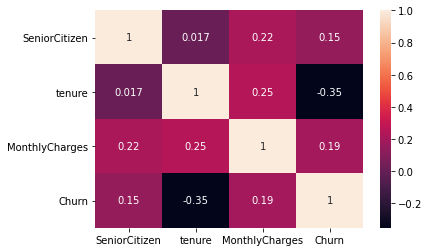

In [24]:
#5 Multicolinearity

import matplotlib.pyplot as plt
import seaborn as sns

correlations_matrix = data.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

# Features are not correlated (good) but also not strongly correlated to the target (not so good)

In [111]:
#6 Splitting X and y

y = data['Churn']
X = data.drop('Churn',axis = 1)

In [26]:
#7 Test/trian split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [27]:
#8 Scaling the features

from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(transformer.transform(X_train),columns=X.columns)

X_test_scaled = pd.DataFrame(transformer.transform(X_test),columns=X.columns)

In [28]:
#9 Resetting index for targets (to make pd.concat work again)

y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True) 

In [75]:
#10 Creating model

from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs')
LR.fit(X_train_scaled, y_train)
display(LR.score(X_test_scaled, y_test))

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

pred = LR.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred)

# Not the greatest recall score despite pretty high overall score.
# Meaning: we are mkissing around 55% of customers that are likely to churn in our predictions

0.7808063600227144

precision:  0.6115942028985507
recall:  0.4557235421166307
f1:  0.5222772277227723


array([[1164,  134],
       [ 252,  211]])

In [94]:
#11 Testing out the SMOTE to see if there will be any improvement

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=100,k_neighbors=3)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_scaled,y_train)

LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_SMOTE, y_train_SMOTE)
display(LR.score(X_test_scaled, y_test))
pred = LR.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

confusion_matrix(y_test,pred)
# much higher recall (good) than initially, despite lower score and precision. Some improvement in f1

0.7194775695627484

precision:  0.4776978417266187
recall:  0.7170626349892009
f1:  0.5734024179620035


array([[935, 363],
       [131, 332]])

In [108]:
#12 Bonus: over & undersampling at the same time

# Apply to train data only

train = pd.concat([X_train_scaled, y_train],axis=1)

from sklearn.utils import resample

no_churn = train[train['Churn']==0]
yes_churn = train[train['Churn']==1]

yes_churn_oversampled = resample(yes_churn,
                                    replace=True, 
                                    n_samples = len(no_churn)-int((len(no_churn)-len(yes_churn))/2),
                                    random_state=2)

no_churn_undersampled = resample(no_churn,
                                    replace=False,
                                    n_samples = len(yes_churn)+int((len(no_churn)-len(yes_churn))/2),
                                    random_state=2)

train_underover = pd.concat([yes_churn_oversampled,no_churn_undersampled])

y = train_underover['Churn']
X = train_underover.drop('Churn',axis = 1)

LR = LogisticRegression(max_iter=100)
LR.fit(X, y)
pred = LR.predict(X_test_scaled)

display(LR.score(X_test_scaled, y_test))
print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

display(confusion_matrix(y_test,pred))

# essentially same results as SMOTE

0.7189097103918228

precision:  0.47701149425287354
recall:  0.7170626349892009
f1:  0.5729076790336497


array([[934, 364],
       [131, 332]])

In [ ]:
# Fun exercise the loop through al three random states (test/trian split and 2x over/undersampling) to see what the maximum recall score can be


import itertools

recall_dict = {}

for a in range(100):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=a)
    transformer = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(transformer.transform(X_train),columns=X.columns)
    X_test_scaled = pd.DataFrame(transformer.transform(X_test),columns=X.columns)
    y_train = y_train.reset_index(drop=True) 
    y_test = y_test.reset_index(drop=True) 

    for b, b in itertools.product(range(100), range(100)):
        
        train = pd.concat([X_train_scaled, y_train],axis=1)

        from sklearn.utils import resample

        no_churn = train[train['Churn']==0]
        yes_churn = train[train['Churn']==1]

        yes_churn_oversampled = resample(yes_churn,
                                            replace=True, 
                                            n_samples = len(no_churn)-int((len(no_churn)-len(yes_churn))/2),
                                            random_state=b)

        no_churn_undersampled = resample(no_churn,
                                            replace=False,
                                            n_samples = len(yes_churn)+int((len(no_churn)-len(yes_churn))/2),
                                            random_state=b)

        train_underover = pd.concat([yes_churn_oversampled,no_churn_undersampled])

        y_underover = train_underover['Churn']
        X_underover = train_underover.drop('Churn',axis = 1)

        LR = LogisticRegression(max_iter=100)
        LR.fit(X_underover, y_underover)
        pred = LR.predict(X_test_scaled)

        recall_dict[round(recall_score(y_test,pred),3)] = a, b, c
        
display(max(recall_dict))
display(recall_dict[max(recall_dict)]) ## So far, getting to 0.788 recall at a = 73, b = 26, c = 9